In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler ,OneHotEncoder , OrdinalEncoder  
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)
from tensorflow.keras import Sequential 
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping


# EDA

In [191]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes


# Data clean

In [192]:
# import data 
df = pd.read_csv('train.csv')
df= df.drop(columns= 'Id')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [193]:
# drop  columns contains a null value 
columns= ['PoolQC','MiscFeature','Fence','Alley' ]
df= df.drop(columns=columns)

In [194]:
num_col = df.select_dtypes('number').columns 
cat_col = df.select_dtypes('object').columns 
df.describe(include='object')

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,1267,1198


In [195]:
#ORDINAL COLUMNS 
ordinal_columns = ['GarageCond','GarageQual','FireplaceQu' , 'KitchenQual','HeatingQC','BsmtCond' ,'ExterQual','ExterCond','BsmtQual']
df[ordinal_columns]

,GarageCond,GarageQual,FireplaceQu,KitchenQual,HeatingQC,BsmtCond,ExterQual,ExterCond,BsmtQual
0,TA,TA,NaN,Gd,Ex,TA,Gd,TA,Gd
1,TA,TA,TA,TA,Ex,TA,TA,TA,Gd
2,TA,TA,TA,Gd,Ex,TA,Gd,TA,Gd
3,TA,TA,Gd,Gd,Gd,Gd,TA,TA,TA
4,TA,TA,TA,Gd,Ex,TA,Gd,TA,Gd
...,...,...,...,...,...,...,...,...,...
1455,TA,TA,TA,TA,Ex,TA,TA,TA,Gd
1456,TA,TA,TA,TA,TA,TA,TA,TA,Gd
1457,TA,TA,Gd,Gd,Ex,Gd,Ex,Gd,TA
1458,TA,TA,NaN,Gd,Gd,TA,TA,TA,TA


In [196]:
cat_col = df.select_dtypes('object').drop (columns=ordinal_columns).columns 
cat_col

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical',
       'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [197]:
df[num_col].isna().sum()


MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
SalePrice          0
dtype: int64

In [198]:
 # LotFrontage # MasVnrArea # GarageYrBlt 
df['LotFrontage']= df['LotFrontage'].astype(float)
df['GarageYrBlt']=df['GarageYrBlt'].astype(float)
df['MasVnrArea']=df['MasVnrArea'].astype(float)


In [199]:
for col in categorical_columns :
  print(f"name {col}")
  print(f"value counts {df[col].value_counts(dropna=False)}\t")
  print("\n")    

name MSZoning
value counts RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64	


name Street
value counts Pave    1454
Grvl       6
Name: Street, dtype: int64	


name LotShape
value counts Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64	


name LandContour
value counts Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64	


name Utilities
value counts AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64	


name LotConfig
value counts Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64	


name LandSlope
value counts Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64	


name Neighborhood
value counts NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge  

# Pre Procissing 

In [200]:
# split data  
y = df['SalePrice']
X = df.drop(columns='SalePrice')
X_train ,X_test , y_train ,y_test= train_test_split(X, y , test_size=0.25 , random_state=42 )

In [201]:
# numarical columns 
#  Create the preprocessing pipeline for numeric data
numeric_columns=X_train.select_dtypes("number").columns
imputer = SimpleImputer(strategy='median')
# Scaler
scaler=StandardScaler()

# Instantiate the pipeline
numeric_pipe= make_pipeline(imputer,scaler)
# Make the tuple for ColumnTransformer
numeric_tuple= ("numarical",numeric_pipe ,numeric_columns )
print(numeric_tuple)

('numarical', Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())]), Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object'))


In [202]:
# Define a list of columns to encode as ordinal
ordinal_columns= ['GarageCond','GarageQual','FireplaceQu' , 'KitchenQual','HeatingQC','BsmtCond' ,'ExterQual','ExterCond','BsmtQual']
# Imputer
imputer= SimpleImputer(strategy='constant', fill_value='NA')
# Specify the order of categories in quality columns
ordinal_order= ['NA','Po','Fa','TA','Gd','Ex']
order2 = ['Fa','TA','Gd','Ex']
order3 = ['Po','Fa','TA','Gd','Ex']
order4= ['NA','Po','Fa','TA','Gd']
order5= ['Fa','TA','Gd','Ex']
order6 =['NA','Fa','TA','Gd','Ex']
# Make the list of order lists for OrdinalEncoder
ordinal_category_orders = [ordinal_order,ordinal_order,ordinal_order,order2,order3 ,order4,order5,order3,order6]


# Instantiate the encoder
ordinal_encoder = OrdinalEncoder(categories=ordinal_category_orders)

# Scaler
scaler_ordinal = StandardScaler()

# Instantiate the pipeline
ordinal_pipe = make_pipeline(imputer, ordinal_encoder,scaler_ordinal)

# Make the tuple for ColumnTransformer
ordinal_tuple = ("Ordinal", ordinal_pipe,ordinal_columns)
print(ordinal_tuple)

('Ordinal', Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='NA', strategy='constant')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['NA', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['Fa', 'TA', 'Gd', 'Ex'],
                                            ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['NA', 'Po', 'Fa', 'TA', 'Gd'],
                                            ['Fa', 'TA', 'Gd', 'Ex'],
                                            ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['NA', 'Fa', 'TA', 'Gd', 'Ex']])),
                ('st

In [203]:
# Create the preprocessing pipeline for categorical  data
categorical_columns =X_train.select_dtypes("object").drop(columns=ordinal_columns).columns
imputer= SimpleImputer(strategy='constant', fill_value='NA')
#OneHotEncoder
oht_categorical = OneHotEncoder(handle_unknown="ignore", sparse_output=False )
X_train_oht = oht_categorical.fit_transform(X_train[categorical_columns])
# Instantiate the pipeline
categorical_pipeline= make_pipeline(imputer,oht_categorical)
# Make the tuple for ColumnTransformer
categorical_tuple= ("categorical" , categorical_pipeline , categorical_columns)
print(categorical_tuple)

('categorical', Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='NA', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical',
       'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object'))


In [204]:
# Create the preprocessing ColumnTransformer
preprocessing_Column= ColumnTransformer([numeric_tuple,ordinal_tuple,categorical_tuple],  remainder="drop", verbose_feature_names_out=False)
preprocessing_Column.fit(X_train)

ColumnTransformer(transformers=[('numarical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF'...
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical',
       'Functional', 'GarageType', 'GarageFinish', 'PavedDrive', 'SaleType',
       'SaleCondition'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [205]:
X_train_tf= preprocessing_Column.transform(X_train)
X_test_tf= preprocessing_Column.transform(X_test)

In [206]:
input_shape= X_train_tf.shape[1]
input_shape

246

# Deep learning

## model 1 

In [207]:
# Build regression model within function
def build_model():
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(128, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(64, 
                activation = 'relu'))
    
    model.add(Dropout(.2))
    model.add(Dense(1, activation = 'linear'))
    
    # Compile Model
    model.compile(loss = 'mse', optimizer = 'adam',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model


  

In [208]:
# Call our build function to build model
reg_model = build_model()

# Get model summary
reg_model.summary()



Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_103 (Dense)           (None, 128)               31616     
                                                                 
 dense_104 (Dense)           (None, 64)                8256      
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_105 (Dense)           (None, 1)                 65        
                                                                 
Total params: 39,937
Trainable params: 39,937
Non-trainable params: 0
_________________________________________________________________


In [209]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [210]:
history = reg_model.fit(X_train_tf, y_train,
                        validation_split = .25,
                        epochs=100,
                        verbose=0, callbacks = [early_stop])

(<Figure size 600x1200 with 3 Axes>,
 array([<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'mean_absolute_error'}>,
        <Axes: title={'center': 'root_mean_squared_error'}>], dtype=object))

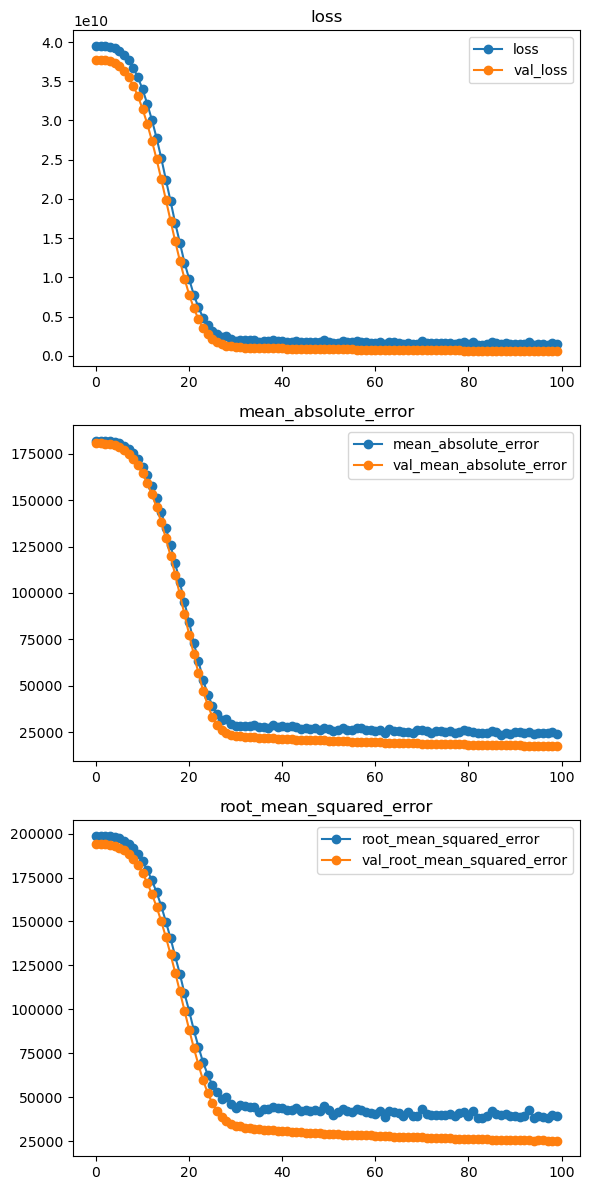

In [211]:
plot_history(history)

In [212]:
# evaluate model
 
y_pred = reg_model.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')


12/12 [==============================] - 0s 2ms/step
final RMSE: 33260.69249508614
final MAE: 19924.135653895548
final R2: 0.8420806766714659


# Model 2 

In [213]:
# Build regression model within function
def build_model():
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(128, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(128, 
                    activation = 'relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, 
                    activation = 'relu'))
     
    model.add(Dense(16, 
                    activation = 'relu'))
    

    
    model.add(Dense(1, activation = 'linear'))
    
    # Compile Model
    model.compile(loss = 'mse', optimizer = 'adam',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model


In [214]:
# Call our build function to build model
model= build_model()

# Get model summary
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_106 (Dense)           (None, 128)               31616     
                                                                 
 dense_107 (Dense)           (None, 128)               16512     
                                                                 
 dropout_25 (Dropout)        (None, 128)               0         
                                                                 
 dense_108 (Dense)           (None, 64)                8256      
                                                                 
 dense_109 (Dense)           (None, 16)                1040      
                                                                 
 dense_110 (Dense)           (None, 1)                 17        
                                                                 
Total params: 57,441
Trainable params: 57,441
Non-tra

In [215]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=4)

In [216]:
history = model.fit(X_train_tf, y_train,
                        validation_split = .25,
                        epochs=100,
                        verbose=0, callbacks = [early_stop])

In [217]:
# evaluate model
 
y_pred = model.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

12/12 [==============================] - 0s 2ms/step
final RMSE: 31175.910816402404
final MAE: 18476.00020333904
final R2: 0.861257025497296


# model 3 

In [218]:
# Build regression model within function
def build_model():
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(256, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(128, 
                    activation = 'relu'))
    
    model.add(Dense(64, 
                    activation = 'relu'))
    model.add(Dropout(.2))
    model.add(Dense(16, 
                    activation = 'relu'))
    

    
    model.add(Dense(1, activation = 'linear'))
    
    # Compile Model
    model.compile(loss = 'mse', optimizer = 'adam',
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model


In [219]:
# Call our build function to build model
model3 = build_model()

# Get model summary
model3.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_111 (Dense)           (None, 256)               63232     
                                                                 
 dense_112 (Dense)           (None, 128)               32896     
                                                                 
 dense_113 (Dense)           (None, 64)                8256      
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_114 (Dense)           (None, 16)                1040      
                                                                 
 dense_115 (Dense)           (None, 1)                 17        
                                                                 
Total params: 105,441
Trainable params: 105,441
Non-t

In [220]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=4)

In [221]:
history = model3.fit(X_train_tf, y_train,
                        validation_split = .25,
                        epochs=150,
                        verbose=0, callbacks = [early_stop])

(<Figure size 600x1200 with 3 Axes>,
 array([<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'mean_absolute_error'}>,
        <Axes: title={'center': 'root_mean_squared_error'}>], dtype=object))

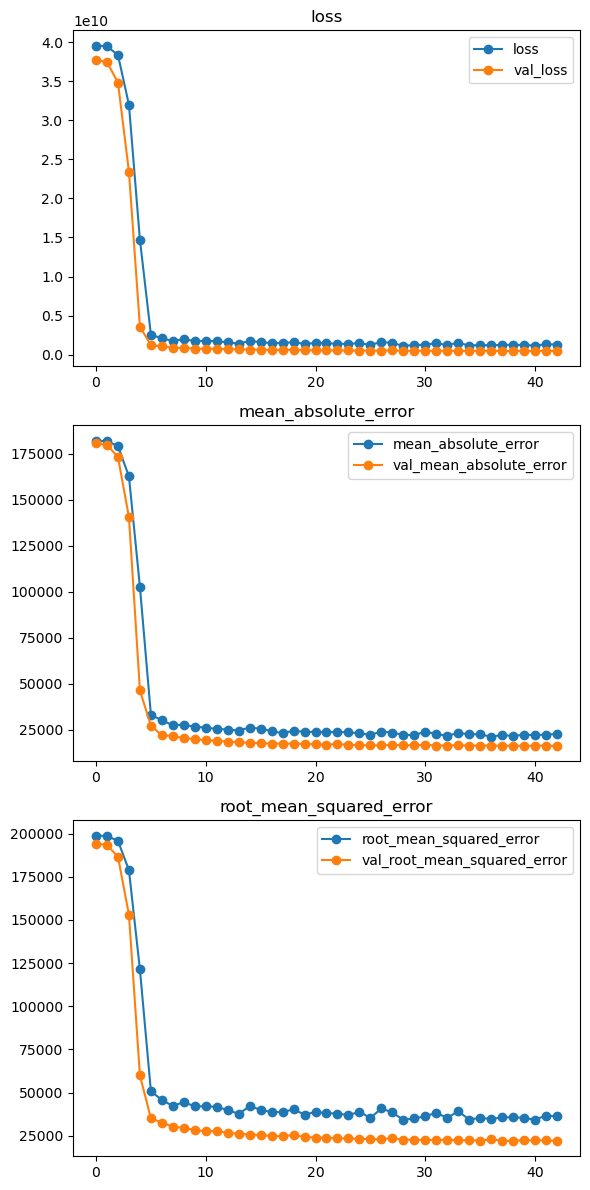

In [222]:
plot_history(history)

In [223]:
# evaluate model
 
y_pred = model3.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

12/12 [==============================] - 0s 2ms/step
final RMSE: 29991.92976727639
final MAE: 17670.74669306507
final R2: 0.8715951224357675


# Model Hyperparameters

In [231]:
from keras_tuner import HyperParameters as hp
import keras_tuner as kt



In [237]:
# Build regression model within function
def build_model(hp):
    # Instantiate Model 
    model = Sequential()
    
    # First hidden layer
    model.add(Dense(256, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(units= hp.Int('units',min_value =64 , max_value= 256 , step=10) ,
                    activation = 'relu'))
    
    model.add(Dense(units= hp.Int('units',min_value =16 , max_value= 128, step=10), 
                    activation = 'relu'))
    model.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(16, 
                    activation = 'relu'))
    

    
    model.add(Dense(1, activation = 'linear'))
    
    # Compile Model
    model.compile(loss = 'mse',optimizer=hp.Choice('optimizer',['rmsprop','nadam','adam']),
             metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model


In [238]:
import os
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [243]:
# Define tuner object
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=100,
                     directory=folder,
                     overwrite = True,
                     seed = 42,
                     project_name='House price')


In [244]:
epochs = 100
tuner.search(X_train_tf,y_train ,epochs=epochs,validation_split =.25 ,callbacks = [early_stop]  )

Trial 254 Complete [00h 00m 09s]
val_loss: 461644224.0

Best val_loss So Far: 447490720.0
Total elapsed time: 00h 15m 28s
INFO:tensorflow:Oracle triggered exit


In [250]:
model_best= tuner.get_best_models()[0]
model_best.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               63232     
                                                                 
 dense_1 (Dense)             (None, 244)               62708     
                                                                 
 dense_2 (Dense)             (None, 244)               59780     
                                                                 
 dropout (Dropout)           (None, 244)               0         
                                                                 
 dense_3 (Dense)             (None, 16)                3920      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 189,657
Trainable params: 189,657
Non-trai

In [253]:
y_pred = model_best.predict(X_test_tf)
 
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

12/12 [==============================] - 0s 2ms/step
final RMSE: 28221.014303483378
final MAE: 17395.832459332192
final R2: 0.88631113311818
